## Objective of the study

Use different classification techniques on the pre-processed diabetes dataset to classify and predict whether a person has diabetes, borderline diabetes or no diabetes.

Specifically, these classficiation techniques are explored:
- Decision Tree
- Random Forest
- XGBoost
- AdaBoost
- Support Vector Machine
- K-Nearest Neighbours
- Logistic Regression
- Neural Network

To ensure consistency across in building and training the different classification models,
- the same train-test split data will be used for model training and evaluation
- the same StratifiedKFold will be used for cross validation
- GridSearchCV will be used to identify the optimal hyperparameters from a list of hyperparameter values provided

Additional steps done and exceptions:
- For the purpose of building intuition, manual hyperparameter testing with visualisation is also done for Decision Tree and Random Forest, on top of using GridSearchCV. However, the final model trained still uses the optimised hyperparameter values identified by GridSearchCV.
- The neural network model uses another train-test split on the training set to create a cross validation set as the model cannot be cross validated with StratifiedKFold.
- The neural network hyperparameters were chosen manually based on trial-and-error.

A confusion matrix will be printed for all models, and the classification report results will be further explored in 06_results_comparison.ipynb 

### Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

### Read the pre-processed dataset

In [28]:
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

In [29]:
# Show the first 5 rows in the dataset
df.head()

,bmi,high_blood_pressure,gender,age,diabetes,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log
0,27.0,1,1,43,1,3,1.722767,1.835776,0.148420
1,33.5,1,1,66,1,3,1.722767,1.704748,0.438255
2,30.2,0,1,34,1,3,1.629241,1.713798,0.173953
3,27.3,0,0,56,1,3,1.609438,1.752672,0.565314
4,21.4,1,1,80,1,3,1.526056,1.597365,0.751416


### Split the dataset into training, cross validation and test sets

The dataset will be split into two parts:
- 80% training set - to train the model
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

Due to the imbalance of classes, StratifiedKFold will be used to split the training set into 5 stratified parts to do cross validation during the training process.

In [30]:
# Split the predictor features and target feature
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1134, 8)
y shape: (1134,)


In [ ]:
# Create a stratified train-test split
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}\n")
print(f"Training set class distribution: {y_train.value_counts()}\n")
print(f"Test set class distribution: {y_test.value_counts()}")

Training set shape: (907, 8)
Test set shape: (227, 8)

Training set class distribution: diabetes
1    742
0    124
2     41
Name: count, dtype: int64

Test set class distribution: diabetes
1    186
0     31
2     10
Name: count, dtype: int64


In [ ]:
# Initialise StratifiedKFold for evaluation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## XGBoost

On top of the hyperparameters seen in the Random Forest Classifier, XGBoost has an additional hyperparameters learning_rate, which specifies the size of the step on gradient descent and prevent overfitting.

XGBoost utilises gradient boosting to build subsequent models that reduce errors of previous iterations by minimising a loss function, and incorporates regularisation to prevent overfitting.

Reference : https://xgboost.readthedocs.io/en/stable/parameter.html

In [ ]:
# Import library
from xgboost import XGBClassifier

In [ ]:
# Define the parameter grid
param_grid = {"n_estimators" : [150, 250],
                "max_depth" : [3, 5],
                "learning_rate" : [0.05, 0.1],
                "reg_lambda" : [1, 5.0],
                "reg_alpha" : [0],
                "gamma" : [0.01, 0.1],
                "subsample": [0.80, 0.90],
                "colsample_bytree": [0.8, 1],
                "min_child_weight": [1,3]
}

# Initialise and run GridSearchCV
xgb_baseline = XGBClassifier(objective="multi:softmax",
                                num_class=3,
                                random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=xgb_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best hyperparameters values: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5.0, 'subsample': 0.9}
Best mean cross-validated score: 0.5351037305874771


c:\Users\ryans\anaconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Optimise the XGBoost model

The optimal XGBoost model will be built using the best hyperparameter values identified by GridSearchCV.

In [ ]:
xgb_model = XGBClassifier(objective="softmax",
                            num_class=3,
                            n_estimators=250,
                            max_depth=5,
                            learning_rate=0.05,
                            reg_lambda=5.0,
                            reg_alpha=0,
                            gamma=0.1,
                            subsample=0.8,
                            colsample_bytree=1,
                            min_child_weight=1,
                            random_state=RANDOM_STATE
                            )

# Fit the optimised XGBClassifier to the training set
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None, num_class=3, ...)

In [ ]:
# Compare recall and f1 scores in training and validation
pred_train = xgb_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.8917519013899816
f1_train : 0.9346802526922525

recall_cv_mean : 0.5194237055847795
f1_cv_mean : 0.5280698544005226


In [ ]:
# Make prediction on the test set
y_pred = xgb_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised XGBoost model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
xgb_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)

cnf_matrix_test_df = pd.DataFrame(xgb_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,20,11,0
Diabetes_no_actual,9,177,0
Diabetes_borderline_actual,3,7,0


In [ ]:
# Generate classification report
xgb_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(xgb_model_classfication_report).T

C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,precision,recall,f1-score,support
Diabetes_yes,0.625000,0.645161,0.634921,31.000000
Diabetes_no,0.907692,0.951613,0.929134,186.000000
Diabetes_borderline,0.000000,0.000000,0.000000,10.000000
accuracy,0.867841,0.867841,0.867841,0.867841
macro avg,0.510897,0.532258,0.521351,227.000000
weighted avg,0.829100,0.867841,0.848024,227.000000


In [ ]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

xgb_model_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb, average="macro", multi_class="ovr")
print(xgb_model_roc_auc)

0.8006539568358159


### Handle Class Imbalance

## Decision Tree model

At each decision node, the decision tree algorithm searches for the best split that maximises the information gain based on the impurity measure specified.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

### Test different hyperparameters

To optimise the decision tree, different values of hyperparameters will be tested to find the value of hyperparameter that produces a reasonably good recall score and F1 score.

Recall is used as the primary evaluation metric as the cost of missing a diabetes case (false negative) outweighs the inconvenience arising from additional screening tests due to false positive diagnoses.

F1 score is used as the secondary metric to ensure that improvements in recall does not result in a significantly high number of false positive diagnoses.

In [ ]:
# Create a list of values for the Decision Tree Classifier hyperparameters to observe their effects on model performance
from sklearn.tree import DecisionTreeClassifier

max_depth_list = [1, 2, 3, 4, 5, 10]
min_samples_split_list = [2, 10, 25, 50, 100, 250]
min_samples_leaf_list = [1, 2, 10, 25, 50, 100, 250]

CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

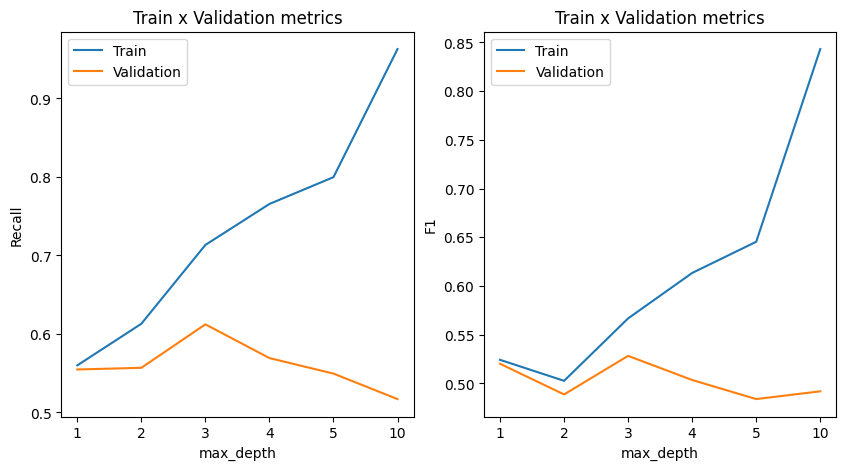

In [35]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    dt = DecisionTreeClassifier(max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, both recall and F1 scores are increasing in training and validation when max_depth approaches 3, before the difference between training and validation increases significantly.

Hence, max_depth=3 is optimal to use for the optimised model.

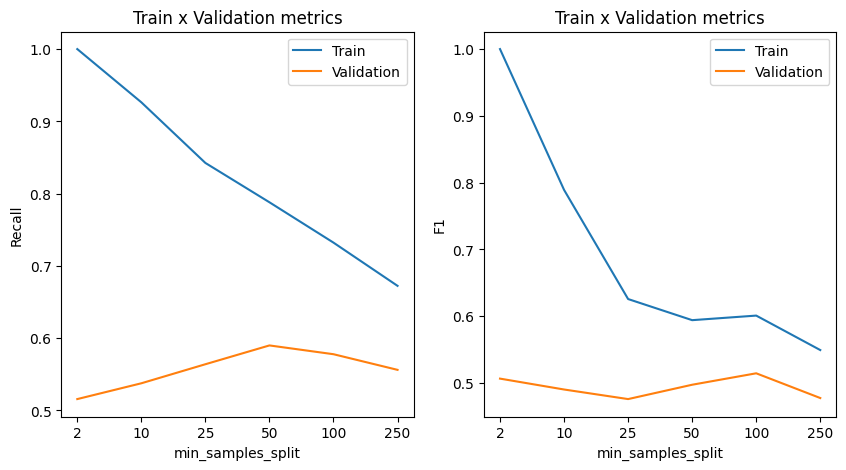

In [36]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

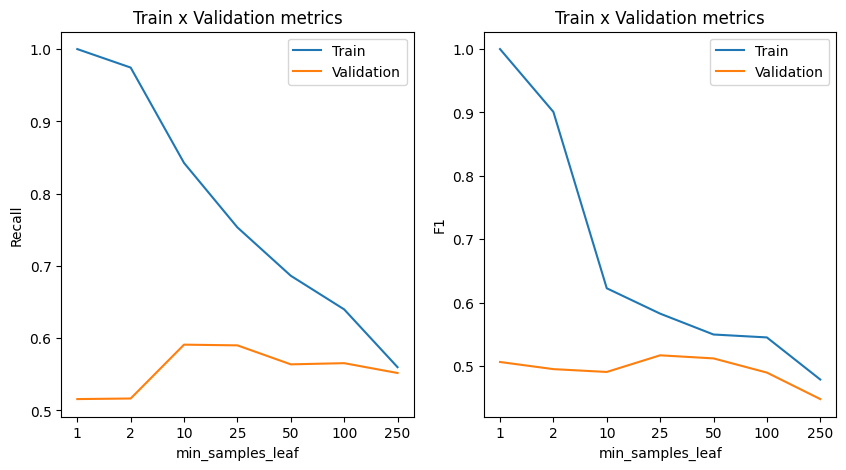

In [37]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the plot of metrics against min_samples_split and min_samples_leaf above, it is hard to determine which are the best values of hyperparameters to use. GridSearchCV will be used to inform us which hyperparameter values are optimal, based on the cross validation score.

### Using GridSearchCV to choose the best hyperparameter values

GridSearchCV tries all possible hyperparameter combinations within a predefined space, which is usually better than trial and error (as done above) that is prone to missing optimal configurations, especially if hyperparameters are tested in silos.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10],
                "min_samples_split" : [2, 10, 25, 50, 100, 250],
                "min_samples_leaf" : [1, 2, 10, 25, 50, 100, 250],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced"]
                }

# Initialise and run GridSearchCV
dt_baseline = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=dt_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv
                            )

# Build a grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameter values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameter values: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best mean cross-validated score: 0.5293644005206755


c:\Users\ryans\anaconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Optimise the decision tree

The optimal decision tree will be built using the best hyperparameter values identified by GridSearchCV.

In [39]:
# Build the optimised decision tree model
dt_model = DecisionTreeClassifier(criterion="gini",
                                    max_depth=3,
                                    min_samples_split=2,
                                    min_samples_leaf=10,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE
                                    )

# Build the decision tree model on the training set
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, random_state=42)

In [40]:
# Compare recall and f1 scores in training and validation
pred_train = dt_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised decision tree model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised decision tree model
recall_train : 0.713362676840402
f1_train : 0.5666489324955579

recall_cv_mean : 0.6144293017850064
f1_cv_mean : 0.5293644005206755


In [41]:
# Predict X_test
y_pred = dt_model.predict(X_test)
y_pred

array([1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1,
       2, 2, 1, 1, 0, 1, 1])

### Visualise the decision tree

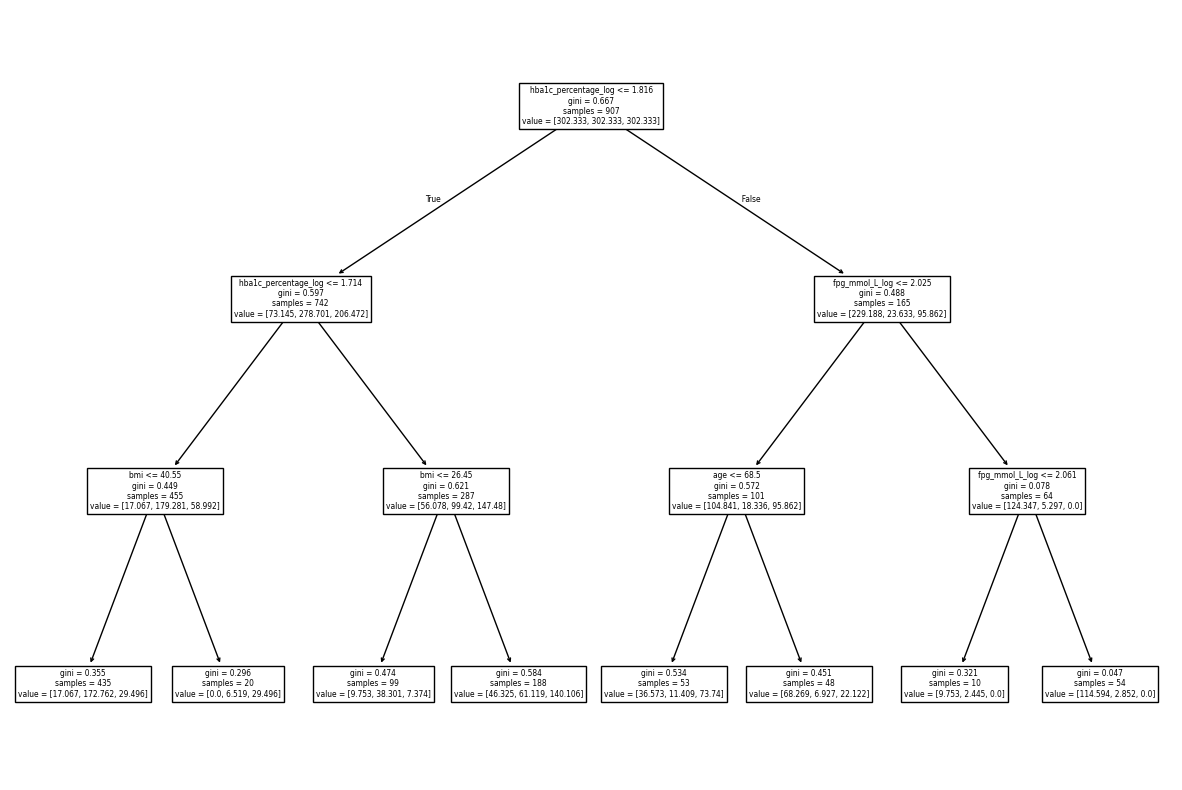

In [42]:
# Show the optimised decision tree model as a plot
from sklearn.tree import plot_tree

feature_cols = X.columns

plt.figure(figsize=(15,10))
plot_tree(dt_model.fit(X_train, y_train), feature_names=feature_cols)
plt.show()

In [43]:
# Show all class names
dt_model.classes_

array([0, 1, 2])

### Confusion Matrix, Classfication Report and AUC_ROC

Evaluation of the optimised decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
dt_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)

cnf_matrix_test_df = pd.DataFrame(dt_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])
cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,14,2,15
Diabetes_no_actual,9,113,64
Diabetes_borderline_actual,4,1,5


In [ ]:
# Generate classification report
dt_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(dt_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.518519,0.451613,0.482759,31.000000
Diabetes_no,0.974138,0.607527,0.748344,186.000000
Diabetes_borderline,0.059524,0.500000,0.106383,10.000000
accuracy,0.581498,0.581498,0.581498,0.581498
macro avg,0.517393,0.519713,0.445829,227.000000
weighted avg,0.871625,0.581498,0.683795,227.000000


In [ ]:
# Generate ROC AUC score
y_pred_proba_dt = dt_model.predict_proba(X_test)

dt_model_roc_auc = roc_auc_score(y_test, y_pred_proba_dt, average="macro", multi_class="ovr")
print(dt_model_roc_auc)

0.7595919170185778


## Random Forest

A random forest algorithm is an ensemble learning method that trains n number of trees with different subsets of features and data. It uses majority voting from these decision trees for the final prediction.

Similar to building an optimised decision tree, different values of hyperparameters will be tested.

An additional hyperparameter is n_estimators, which specifies the number of decision trees that make up the random forest.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Create a list of values for the Random Forest Classifier parameters to observe their effects on model performance
max_depth_list = [1, 2, 3, 4, 5, 10]
min_samples_split_list = [2, 10, 25, 50, 100, 250]
min_samples_leaf_list = [1, 2, 10, 25, 50, 100, 250]
n_estimators_list = [10, 15, 25, 50, 75, 100]

CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

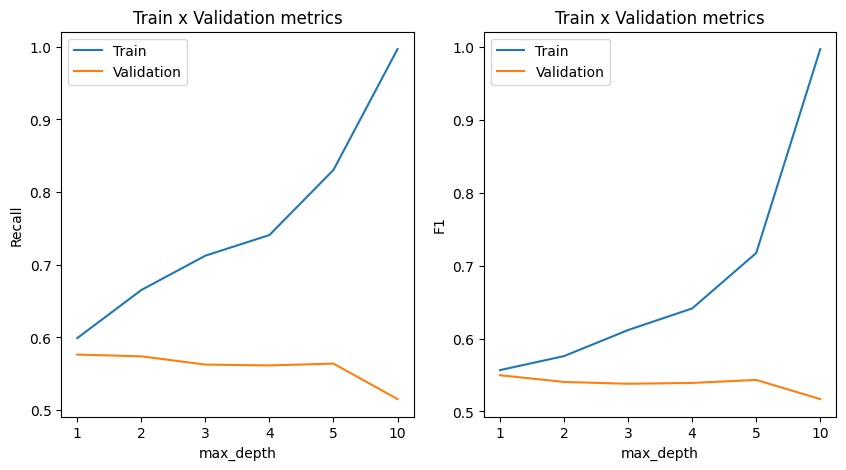

In [49]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    rf = RandomForestClassifier(max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

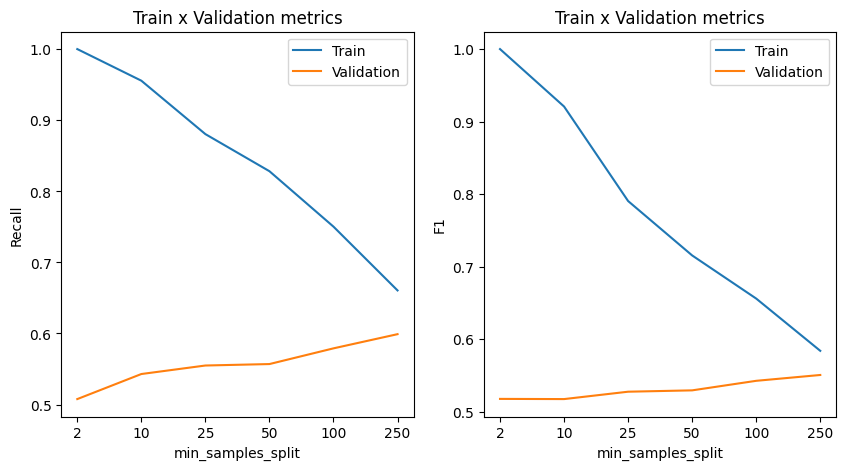

In [50]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    rf = RandomForestClassifier(min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

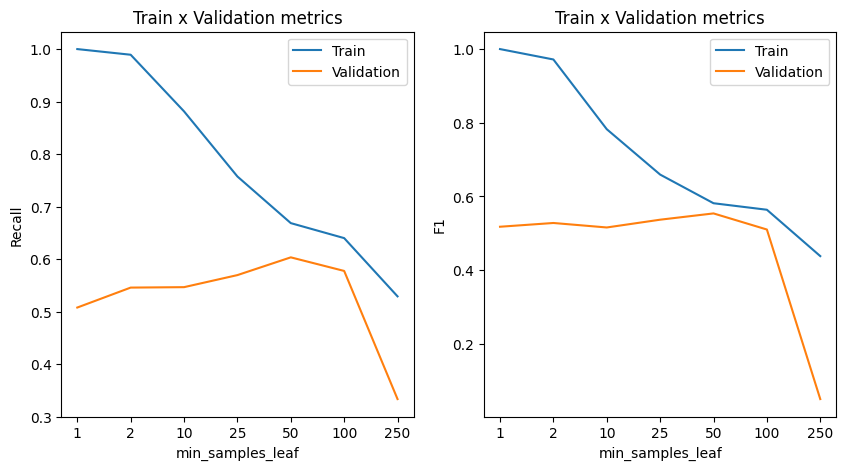

In [51]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

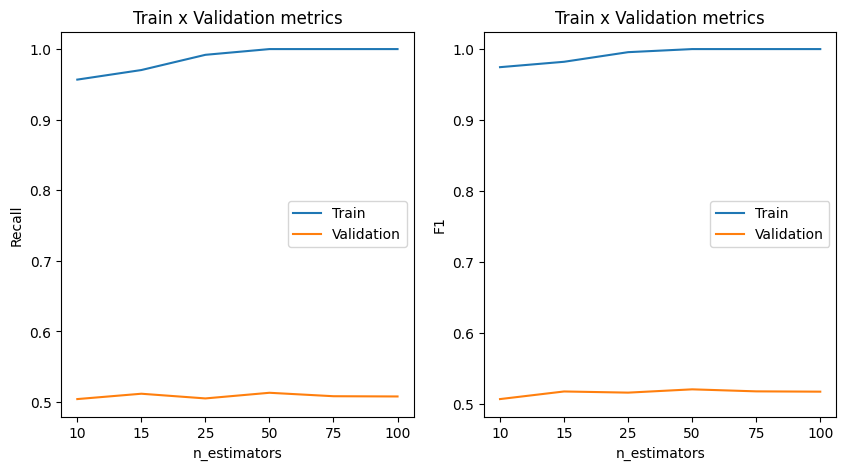

In [52]:
# Evaluating n_estimators
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("F1")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

In [53]:
# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10],
                "min_samples_split" : [2, 10, 25, 50, 100, 250],
                "min_samples_leaf" : [1, 2, 10, 25, 50, 100, 250],
                "n_estimators" : [10, 15, 25, 50, 75, 100],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced"]
}

# Initialise and run GridSearchCV
rf_baseline = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1
                            )

# Build the grid search on the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameters values: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
Best mean cross-validated score: 0.5650612536711218


c:\Users\ryans\anaconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Optimise the Random Forest model

The optimal random forest model will be built using the best hyperparameter values identified by GridSearchCV.

In [54]:
# Build the optimised random forest model
rf_model = RandomForestClassifier(criterion="gini",
                                    max_depth=5,
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    n_estimators=25,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE
                                    )

# Build the random forest model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, n_estimators=25, random_state=42)

In [55]:
# Compare recall and f1 scores in training and validation
pred_train = rf_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.8003036851514502
f1_train : 0.697791515720238

recall_cv_mean : 0.5573941794143137
f1_cv_mean : 0.5340114364762747


In [56]:
# Predict X_test
y_pred = rf_model.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1,
       1, 1, 1, 1, 2, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised random forest model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
rf_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

cnf_matrix_test_df = pd.DataFrame(rf_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,24,5,2
Diabetes_no_actual,12,155,19
Diabetes_borderline_actual,3,4,3


In [ ]:
# Generate classification report
rf_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(rf_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.615385,0.774194,0.685714,31.000000
Diabetes_no,0.945122,0.833333,0.885714,186.000000
Diabetes_borderline,0.125000,0.300000,0.176471,10.000000
accuracy,0.801762,0.801762,0.801762,0.801762
macro avg,0.561836,0.635842,0.582633,227.000000
weighted avg,0.863963,0.801762,0.827157,227.000000


In [ ]:
# Generate ROC AUC score
from sklearn.metrics import roc_auc_score

y_pred_proba_rf = rf_model.predict_proba(X_test)

rf_model_roc_auc = roc_auc_score(y_test, y_pred_proba_rf, average="macro", multi_class="ovr")
print(rf_model_roc_auc)

0.8039810993896642


## AdaBoost

AdaBoost iteratively trains a set of weak learners (models that perform slightly better than random guessing) on different parts of the data. In each iteration, the weights of misclassified examples are increased such that subsequent weak learners focus more on these misclassified examples. The final prediction is a weighted vote from all weak learners, where the weight is determined by the accuracy of the weak learner.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [68]:
# Import library
from sklearn.ensemble import AdaBoostClassifier

In [69]:
# Define the parameter grid
param_grid = {"n_estimators" : [50, 100, 150],
                "learning_rate" : [0.01, 0.2, 0.3],
                "estimator__criterion": ["gini", "entropy"],
                "estimator__max_depth": [2, 3, 5],
                "estimator__min_samples_split": [5, 10, 25],
                "estimator__min_samples_leaf": [1, 5, 10],
}

# Initialise and run GridSearchCV
weak_learner = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
adb_baseline = AdaBoostClassifier(estimator=weak_learner,
                                    algorithm="SAMME",
                                    random_state=RANDOM_STATE,    
                                    )
grid_search = GridSearchCV(estimator=adb_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best hyperparameters values: {'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.2, 'n_estimators': 50}
Best mean cross-validated score: 0.5450219215503821


c:\Users\ryans\anaconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Optimise the AdaBoost model

The optimal AdaBoost model will be built using the best hyperparameter values identified by GridSearchCV.

In [70]:
adb_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion="gini",
                                                            max_depth=2,
                                                            min_samples_split=5,
                                                            min_samples_leaf=1,
                                                            class_weight=CLASS_WEIGHT,
                                                            random_state=RANDOM_STATE                                                            
                                                            ),
                            n_estimators=50,
                            learning_rate=0.2,
                            algorithm="SAMME",
                            random_state=RANDOM_STATE
                            )

# Fit the optimised AdaBoostClassifier to the training set
adb_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=2,
                                                    min_samples_split=5,
                                                    random_state=42),
                   learning_rate=0.2, random_state=42)

In [71]:
# Compare recall and f1 scores in training and validation
pred_train = adb_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(adb_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(adb_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.6279455727780476
f1_train : 0.5559920890327837

recall_cv_mean : 0.5726246111883696
f1_cv_mean : 0.5450219215503821


In [72]:
# Make prediction on the test set
y_pred = adb_model.predict(X_test)
y_pred

array([2, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1,
       2, 2, 1, 1, 2, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised AdaBoost model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
adb_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=adb_model.classes_)

cnf_matrix_test_df = pd.DataFrame(adb_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,19,2,10
Diabetes_no_actual,3,127,56
Diabetes_borderline_actual,2,2,6


In [ ]:
# Generate classification report
adb_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(adb_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.791667,0.612903,0.690909,31.000000
Diabetes_no,0.969466,0.682796,0.801262,186.000000
Diabetes_borderline,0.083333,0.600000,0.146341,10.000000
accuracy,0.669604,0.669604,0.669604,0.669604
macro avg,0.614822,0.631900,0.546171,227.000000
weighted avg,0.906148,0.669604,0.757341,227.000000


In [ ]:
# Generate ROC AUC score
y_pred_proba_adb = adb_model.predict_proba(X_test)

adb_model_roc_auc = roc_auc_score(y_test, y_pred_proba_adb, average="macro", multi_class="ovr")
print(adb_model_roc_auc)

0.8182438435641762


## Feature Scaling

The remaining methods to be explored are more sensitive to the scale of the feature values. Hence, feature scaling will be introduced.

A pipeline is needed to prevent data leakage. make_pipeline will be used to create a sequential workflow that chains multiple steps together:
1. StandardScaler fits on the training fold of the StratifiedKFold and transforms it
2. The same scaler fitted on the training fold transforms the validation fold of the StratifiedKFold
3. The model trains on the scaled training data
4. The model predicts on the scaled validation data

Since the validation fold does not influence the scaling parameters, no data is leaked.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [76]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Logistic Regression

Multinomial logistic regression predicts the probability of an example belonging to each class using a softmax function.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [77]:
# Import library
from sklearn.linear_model import LogisticRegression

In [78]:
# Initialise the pipeline with StandardScaler and Logistic Regression
pipe = make_pipeline(StandardScaler(),
                    LogisticRegression(class_weight=CLASS_WEIGHT,
                                        random_state=RANDOM_STATE,
                                        multi_class="multinomial",
                                        n_jobs=-1
                                        )
                    )

In [79]:
# Define the parameter grid
param_grid = {"logisticregression__penalty" : ["l2", "l1", "elasticnet"],
                "logisticregression__solver" : ["lbfgs", "newton-cholesky", "saga"],
                "logisticregression__max_iter": [100, 200]
}

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters values: {'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best mean cross-validated score: 0.5192818135035855


C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryans\AppData\Roaming\Python\Python312\site-p

### Optimise the Logistic Regression model

The optimal Logistic Regression model will be built using the best hyperparameter values identified by GridSearchCV.

In [80]:
lgr_optimised = LogisticRegression(penalty="l2",
                                solver="lbfgs",
                                max_iter=50,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE,
                                multi_class="multinomial",
                                n_jobs=-1
                                    )

# Create pipeline with the optimised Logistic Regression hyperparameter values
lgr_model = make_pipeline(StandardScaler(), lgr_optimised)

# Fit the optimised Logistic Regression model to the training set
lgr_model.fit(X_train, y_train)

C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=50,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=42))])

In [81]:
lgr_optimised_cv = LogisticRegression(penalty="l2",
                                solver="lbfgs",
                                max_iter=50,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE,
                                multi_class="multinomial",
                                n_jobs=-1
                                        )

# Create a pipeline for cross validation
lgr_model_cv = make_pipeline(StandardScaler(), lgr_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = lgr_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(lgr_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(lgr_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised logistic regression model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_mo

Comparison of recall and f1 scores in the training and validation of the optimised logistic regression model
recall_train : 0.6318213403853888
f1_train : 0.5440751131855726

recall_cv_mean : 0.5590507218628025
f1_cv_mean : 0.510728884231181


C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ryans\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_mo

In [82]:
# Make prediction on the test set
y_pred = lgr_model.predict(X_test)
y_pred

array([1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 1, 2, 2, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Logistic Regression model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
lgr_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=lgr_model.classes_)

cnf_matrix_test_df = pd.DataFrame(lgr_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,22,4,5
Diabetes_no_actual,9,123,54
Diabetes_borderline_actual,2,3,5


In [ ]:
# Generate classification report
lgr_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(lgr_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.666667,0.709677,0.687500,31.000000
Diabetes_no,0.946154,0.661290,0.778481,186.000000
Diabetes_borderline,0.078125,0.500000,0.135135,10.000000
accuracy,0.660793,0.660793,0.660793,0.660793
macro avg,0.563649,0.623656,0.533705,227.000000
weighted avg,0.869747,0.660793,0.737715,227.000000


In [ ]:
# Generate ROC AUC score
y_pred_proba_lgr = lgr_model.predict_proba(X_test)

lgr_model_roc_auc = roc_auc_score(y_test, y_pred_proba_lgr, average="macro", multi_class="ovr")
print(lgr_model_roc_auc)

0.817048461136356


## k-Nearest Neighbours

k-Nearest Neighbors is a lazy learning algorithm that classifies new examples based on the majority voting of the k-nearest neighbors in the feature space.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [86]:
# Import library
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Initialise the pipeline with StandardScaler and KNeighborsClassifier
pipe = make_pipeline(StandardScaler(),
                    KNeighborsClassifier(algorithm="auto",
                                        metric="minkowski",
                                        n_jobs=-1
                                        )
                    )

In [88]:
# Define the parameter grid
param_grid = {"kneighborsclassifier__n_neighbors" : [3, 5, 7, 9],
                "kneighborsclassifier__weights" : ["uniform", "distance"],
                "kneighborsclassifier__p": [1, 2]
}

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters values: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Best mean cross-validated score: 0.5084652524858677


c:\Users\ryans\anaconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Optimise the k-Nearest Neighbors model

The optimal k-Nearest Neighbors model will be built using the best hyperparameter values identified by GridSearchCV.

In [89]:
knn_optimised = KNeighborsClassifier(n_neighbors=5,
                                    weights="distance",
                                    p=1,
                                    algorithm="auto",
                                    metric="minkowski",
                                    n_jobs=-1
                                    )

# Create pipeline with the optimised kNN hyperparameter values
knn_model = make_pipeline(StandardScaler(), knn_optimised)

# Fit the optimised kNN model to the training set
knn_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_jobs=-1, p=1, weights='distance'))])

In [90]:
knn_optimised_cv = KNeighborsClassifier(n_neighbors=5,
                                        weights="distance",
                                        p=1,
                                        algorithm="auto",
                                        metric="minkowski",
                                        n_jobs=-1
                                        )

# Create a pipeline for cross validation
knn_model_cv = make_pipeline(StandardScaler(), knn_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = knn_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(knn_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(knn_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised k-nearest neighbors model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised k-nearest neighbors model
recall_train : 1.0
f1_train : 1.0

recall_cv_mean : 0.4877779188584558
f1_cv_mean : 0.5084652524858677


In [91]:
# Make prediction on the test set
y_pred = knn_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised k-Nearest Neighbors model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
knn_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)

cnf_matrix_test_df = pd.DataFrame(knn_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,13,15,3
Diabetes_no_actual,6,177,3
Diabetes_borderline_actual,2,8,0


In [ ]:
# Generate classification report
knn_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(knn_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.619048,0.419355,0.500000,31.000000
Diabetes_no,0.885000,0.951613,0.917098,186.000000
Diabetes_borderline,0.000000,0.000000,0.000000,10.000000
accuracy,0.837004,0.837004,0.837004,0.837004
macro avg,0.501349,0.456989,0.472366,227.000000
weighted avg,0.809694,0.837004,0.819737,227.000000


In [ ]:
# Generate ROC AUC score
y_pred_proba_knn = knn_model.predict_proba(X_test)

knn_model_roc_auc = roc_auc_score(y_test, y_pred_proba_knn, average="macro", multi_class="ovr")
print(knn_model_roc_auc)

0.7459170292822086


## Support Vector Machine

Support vector machines find optimal hyperplanes that maximises the separation between classes. One-vs-Rest (ovr) strategy is used, training a classifier for each class that treats itself as the positive class and all other classes as the negative class.

SVC is used as medical data often have non-linear relationships, which SVC can capture better compared to LinearSVC.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [95]:
# Import library
from sklearn.svm import SVC

In [ ]:
# Initialise the pipeline with StandardScaler and SVC
pipe = make_pipeline(StandardScaler(),
                    SVC(probability=True,
                        class_weight="balanced",
                        decision_function_shape="ovr",
                        random_state=RANDOM_STATE
                        )
                    )

In [97]:
# Define the parameter grid
param_grid = {"svc__C" : [0.01, 0.1, 0.5, 1.0],
                "svc__kernel" : ["linear", "poly", "rbf", "sigmoid"],
                "svc__degree" : [2, 3, 4],
                "svc__gamma" : ["scale", "auto", 0.01, 0.1, 0.5]
            }

# Initialise and run GridSearchCV
grid_search = GridSearchCV(estimator=pipe,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best hyperparameters values: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
Best mean cross-validated score: 0.5252639154346778


### Optimise the Support Vector Machine model

The optimal Support Vector Machine model will be built using the best hyperparameter values identified by GridSearchCV.

In [98]:
svc_optimised = SVC(C=0.1,
                    kernel="poly",
                    degree=3,
                    gamma=0.1,
                    probability=True,
                    class_weight="balanced",
                    decision_function_shape="ovr",
                    random_state=RANDOM_STATE
                    )

# Create pipeline with the optimised kNN hyperparameter values
svc_model = make_pipeline(StandardScaler(), svc_optimised)

# Fit the optimised SVC model to the training set
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced', gamma=0.1, kernel='poly',
                     probability=True, random_state=42))])

In [99]:
svc_optimised_cv = SVC(C=0.1,
                    kernel="poly",
                    degree=3,
                    gamma=0.1,
                    probability=True,
                    class_weight="balanced",
                    decision_function_shape="ovr",
                    random_state=RANDOM_STATE
                    )

# Create a pipeline for cross validation
svc_model_cv = make_pipeline(StandardScaler(), svc_optimised_cv)

# Retrieve recall and f1 score for training
pred_train = svc_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

# Retreive recall and f1 score for cross validation
recall_cv = cross_val_score(svc_model_cv, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(svc_model_cv, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised SVC model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised SVC model
recall_train : 0.6316992230438782
f1_train : 0.5863511284828472

recall_cv_mean : 0.5241307750703724
f1_cv_mean : 0.5252639154346778


In [100]:
# Make prediction on the test set
y_pred = svc_model.predict(X_test)
y_pred

array([1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Support Vector Machine model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
svc_cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=svc_model.classes_)

cnf_matrix_test_df = pd.DataFrame(svc_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,12,6,13
Diabetes_no_actual,2,163,21
Diabetes_borderline_actual,2,5,3


In [ ]:
# Generate classification report
svc_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(svc_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.750000,0.387097,0.510638,31.000000
Diabetes_no,0.936782,0.876344,0.905556,186.000000
Diabetes_borderline,0.081081,0.300000,0.127660,10.000000
accuracy,0.784141,0.784141,0.784141,0.784141
macro avg,0.589288,0.521147,0.514618,227.000000
weighted avg,0.873578,0.784141,0.817356,227.000000


In [ ]:
# Generate ROC AUC score
y_pred_proba_svc = svc_model.predict_proba(X_test)

svc_model_roc_auc = roc_auc_score(y_test, y_pred_proba_svc, average="macro", multi_class="ovr")
print(svc_model_roc_auc)

0.7976361748475944


## Neural Network

Neural networks use multiple layers of interconnected nodes to learn non-linear patterns. The output layer contains one neuron per class, and a linear activation with softmax function is used to determine the probability of the example belonging to the class.

Reference : https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [104]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import ParameterGrid

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [105]:
# For consistent results
tf.random.set_seed(RANDOM_STATE)

# Normalise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
# Handle class imbalance by computing class weights
class_weights = compute_class_weight(class_weight=CLASS_WEIGHT, classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(2.4381720430107525),
 1: np.float64(0.40745732255166217),
 2: np.float64(7.373983739837398)}

In [107]:
# Create model function for GridSearchCV
def create_model(units_layer1=256, units_layer2=128, units_layer3=64, units_layer4=32, activation="relu", dropout_rate=0.3, learning_rate=1e-5):
    model = Sequential([tf.keras.Input(shape=(8,)),
                        Dense(units_layer1, activation=activation, name="layer1"),
                        Dropout(dropout_rate, name="dropout1"),
                        Dense(units_layer2, activation=activation, name="layer2"),
                        Dropout(dropout_rate, name="dropout2"),
                        Dense(units_layer3, activation=activation, name="layer3"),
                        Dense(units_layer4, activation=activation, name="layer4"),
                        Dense(3, activation="linear", name="output")
        
    ])
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=Adam(learning_rate=learning_rate),
                    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

Grid Search hyperparameter tuning for neural networks : https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [108]:
# Hyperparameter search with stratified cross validation
def stratified_hyperparameter_search(X, y, param_grid, n_splits=5):
    best_score = 0
    best_params = {}
    
    # Use ParameterGrid to iterate over parameter value combinations
    for params in ParameterGrid(param_grid):
        print(f"Testing: {params}")
        
        # Create KerasClassifier wrapper
        model = KerasClassifier(
            model=create_model,
            verbose=0,
            class_weight=class_weights_dict,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5)],
            **params
        )
        
        # Use sklearn's cross_val_score with stratified CV
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
        
        mean_score = scores.mean()
        print(f"CV Score: {mean_score:.4f} (+/- {scores.std() * 2:.4f})")
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params.copy()
    
    return best_params, best_score

# Define param_grid
param_grid = {
    "units_layer1" : [128, 256],
    "units_layer2" : [64, 128],
    "units_layer3" : [32, 64],
    "units_layer4" : [16, 32],
    "dropout_rate" : [0.2, 0.3],
    "learning_rate" : [1e-5, 1e-4],
    "epochs" : [50, 100],
    "batch_size" : [16, 32]
}

# Run search
best_params, best_score = stratified_hyperparameter_search(
    X_train_scaled, y_train, param_grid, n_splits=5
)

print(f"\nBest Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Testing: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 1e-05, 'units_layer1': 128, 'units_layer2': 64, 'units_layer3': 32, 'units_layer4': 16}
CV Score: 0.4297 (+/- 0.2559)
Testing: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 1e-05, 'units_layer1': 128, 'units_layer2': 64, 'units_layer3': 32, 'units_layer4': 32}
CV Score: 0.3087 (+/- 0.0812)
Testing: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 1e-05, 'units_layer1': 128, 'units_layer2': 64, 'units_layer3': 64, 'units_layer4': 16}
CV Score: 0.4258 (+/- 0.1054)
Testing: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 1e-05, 'units_layer1': 128, 'units_layer2': 64, 'units_layer3': 64, 'units_layer4': 32}
CV Score: 0.4313 (+/- 0.0635)
Testing: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 1e-05, 'units_layer1': 128, 'units_layer2': 128, 'units_layer3': 32, 'units_layer4': 16}
CV Score: 0.4460 (+/- 0.0842)
Testing: 

In [109]:
best_params

{'batch_size': 16,
 'dropout_rate': 0.3,
 'epochs': 50,
 'learning_rate': 0.0001,
 'units_layer1': 128,
 'units_layer2': 64,
 'units_layer3': 32,
 'units_layer4': 16}

In [110]:
# Build the optimised neural network model
nn_model = Sequential([tf.keras.Input(shape=(8, )),
                    Dense(best_params["units_layer1"], activation="relu", name="layer1"),
                    Dropout(best_params["dropout_rate"], name="dropout1"),
                    Dense(best_params["units_layer2"], activation="relu", name="layer2"),
                    Dropout(best_params["dropout_rate"], name="dropout2"),
                    Dense(best_params["units_layer3"], activation="relu", name="layer3"),
                    Dense(best_params["units_layer4"], activation="relu", name="layer4"),
                    Dense(3, activation="linear", name="output")
                    ])

In [111]:
nn_model.summary()

Model: "sequential_1280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,067 (47.14 KB)

 Trainable params: 12,067 (47.14 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# Compile the model with a loss function, optimizer and metrics
nn_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.F1Score(average="macro"), tf.keras.metrics.AUC(multi_label=True, num_labels=3)]
)

In [113]:
# Set up callbacks for early stopping and learning rate reduction for better training
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)]

# Create a validation set from the training set to evaluate the optimised model
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

# Train the model with the training and validation data
history = nn_model.fit(
    X_train_split, y_train_split,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    validation_data=(X_val,y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - auc: 0.4661 - f1_score: 0.3324 - loss: 1.0585 - sparse_categorical_accuracy: 0.1322 - val_auc: 0.3949 - val_f1_score: 0.3605 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.1978 - learning_rate: 1.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.4202 - f1_score: 0.3469 - loss: 1.0257 - sparse_categorical_accuracy: 0.1664 - val_auc: 0.3885 - val_f1_score: 0.3813 - val_loss: 1.1095 - val_sparse_categorical_accuracy: 0.2418 - learning_rate: 1.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.4885 - f1_score: 0.3667 - loss: 1.0152 - sparse_categorical_accuracy: 0.2067 - val_auc: 0.3899 - val_f1_score: 0.4004 - val_loss: 1.0934 - val_sparse_categorical_accuracy: 0.3132 - learning_rate: 1.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.4259 - f1_score: 0.3884 - loss: 1.0147 - sparse_categorical_accuracy: 0.2454 - val_auc: 0.3876 - val_f1_score: 0.4275 - val_loss: 1.0773 - val

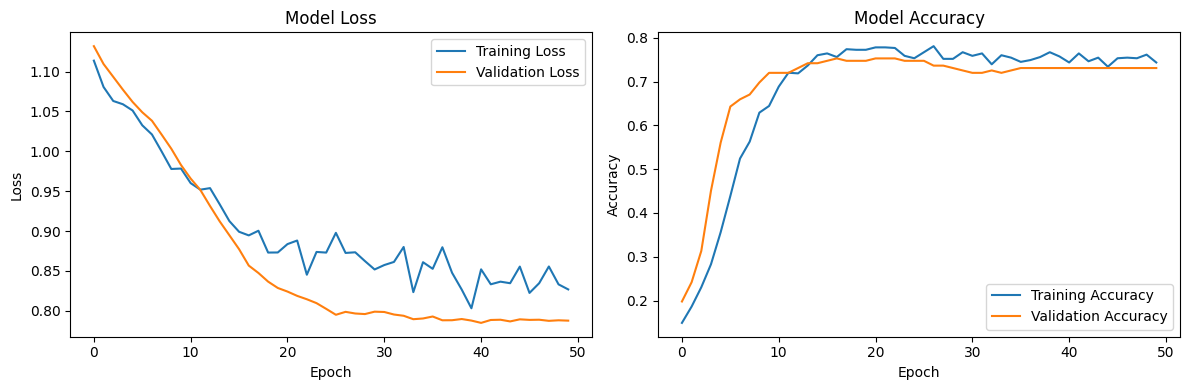

In [114]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [115]:
# Make predictions on the test set and covert logits to probabilities
y_pred_logits = nn_model.predict(X_test_scaled)
y_pred_proba_nn = tf.nn.softmax(y_pred_logits).numpy()

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba_nn, axis=1)
y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


array([1, 0, 2, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0,
       1, 1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 1, 1])

### Confusion Matrix, Classfication Report and AUC-ROC

Evaluation of the optimised Neural Network model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [ ]:
# Generate confusion matrix and display with each row and column labelled
nn_cnf_matrix_test = confusion_matrix(y_test, y_pred)

cnf_matrix_test_df = pd.DataFrame(nn_cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,24,3,4
Diabetes_no_actual,14,133,39
Diabetes_borderline_actual,4,5,1


In [ ]:
# Generate classification report
nn_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"], output_dict=True)
pd.DataFrame.from_dict(nn_model_classfication_report).T

,precision,recall,f1-score,support
Diabetes_yes,0.571429,0.774194,0.657534,31.000000
Diabetes_no,0.943262,0.715054,0.813456,186.000000
Diabetes_borderline,0.022727,0.100000,0.037037,10.000000
accuracy,0.696035,0.696035,0.696035,0.696035
macro avg,0.512473,0.529749,0.502676,227.000000
weighted avg,0.851931,0.696035,0.757959,227.000000


In [ ]:
# Generate ROC AUC score
nn_model_roc_auc = roc_auc_score(y_test, y_pred_proba_nn, average="macro", multi_class="ovr")
print(nn_model_roc_auc)

0.7893018156646345


## Save all models and results

To use these trained models and results in the other notebooks for interpreting and comparing results

Choice between joblib and pickle:
- joblib is used to save scikit-learn models or large NumPy arrays
- pickle is used to save Python objects that are not well supported by joblib, such as complex dictionaries, custom classes and metadata

Reference : https://medium.com/nlplanet/is-it-better-to-save-models-using-joblib-or-pickle-776722b5a095

In [119]:
# Save models and metadata
import os
import joblib
import pickle

os.makedirs("../models", exist_ok=True)

models = {
            "Decision Tree" : dt_model,
            "Random Forest" : rf_model,
            "XGBoost" : xgb_model,
            "AdaBoost" : adb_model,
            "Logistic Regression" : lgr_model,
            "k-Nearest Neighbors": knn_model,
            "Support Vector Machine": svc_model
        }

for model_name, model in models.items():
    joblib.dump(model, f"../models/{model_name.lower().replace(' ', '_')}_model.pkl")

nn_model.save("../models/neural_network_model.keras", include_optimizer=True)

metadata = {
    "feature_names" : X_train.columns.tolist(),
    "class_names": ["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"],
    "train_shape" : X_train.shape,
    "test_shape" : X_test.shape
}

with open("../data/results/metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

In [120]:
# Save training and test data
model_data = {
    "X_train": X_train,
    "X_train_scaled": X_train_scaled,
    "y_train": y_train,
    "X_test": X_test,
    "X_test_scaled": X_test_scaled,
    "y_test": y_test
}

with open("../data/results/split_data.pkl", "wb") as f:
    pickle.dump(model_data, f)

In [121]:
# Save model results
model_results = {
    "confusion_matrices" : {
        "Decision Tree": dt_cnf_matrix_test,
        "Random Forest": rf_cnf_matrix_test,
        "XGBoost": xgb_cnf_matrix_test,
        "AdaBoost" : adb_cnf_matrix_test,
        "Logistic Regression": lgr_cnf_matrix_test,
        "k-Nearest Neighbors": knn_cnf_matrix_test,
        "Support Vector Machine": svc_cnf_matrix_test,
        "Neural Network": nn_cnf_matrix_test
    },
    "pred_proba" : {
        "Decision Tree": y_pred_proba_dt,
        "Random Forest": y_pred_proba_rf,
        "XGBoost": y_pred_proba_xgb,
        "AdaBoost" : y_pred_proba_adb,
        "Logistic Regression": y_pred_proba_lgr,
        "k-Nearest Neighbors": y_pred_proba_knn,
        "Support Vector Machine": y_pred_proba_svc,
        "Neural Network": y_pred_proba_nn
    },
    "auc_scores" : {
        "Decision Tree": dt_model_roc_auc,
        "Random Forest": rf_model_roc_auc,
        "XGBoost": xgb_model_roc_auc,
        "AdaBoost" : adb_model_roc_auc,
        "Logistic Regression": lgr_model_roc_auc,
        "k-Nearest Neighbors": knn_model_roc_auc,
        "Support Vector Machine": svc_model_roc_auc,
        "Neural Network": nn_model_roc_auc
    },
    "classification_reports" : {
        "Decision Tree": dt_model_classfication_report,
        "Random Forest": rf_model_classfication_report,
        "XGBoost": xgb_model_classfication_report,
        "AdaBoost" : adb_model_classfication_report,
        "Logistic Regression": lgr_model_classfication_report,
        "k-Nearest Neighbors": knn_model_classfication_report,
        "Support Vector Machine": svc_model_classfication_report,
        "Neural Network": nn_model_classfication_report
    }
}

with open("../data/results/model_results.pkl", "wb") as f:
    pickle.dump(model_results, f)